# Deep Learning for Time Series Forecasting - Tensorflow

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')
# plt.rc("figure", figsize=(16, 4))

import matplotlib 
import tensorflow as tf

print(f'''
Matplotlib -> {matplotlib.__version__}
pandas -> {pd.__version__}   
numpy -> {np.__version__}
tensorflow -> {tf.__version__}
''')

###### configurations for image quality#######
plt.rcParams["figure.figsize"] = [14, 7]   ##
# plt.rcParams['figure.dpi'] = 300           ## 300 for printing
plt.rc('font', size=8)                     ## 
plt.rc('axes', titlesize=16)               ## 
plt.rc('axes', labelsize=14)               ##
plt.rc('xtick', labelsize=10)              ##
plt.rc('ytick', labelsize=10)              ##
plt.rc('legend', fontsize=10)              ##
plt.rc('figure', titlesize=12)             ## 
#############################################


Matplotlib -> 3.5.2
pandas -> 1.4.4   
numpy -> 1.22.3
tensorflow -> 2.10.0



### Preparing Time Series Data for Deep Learning

<Day>
<MonthBegin>
<MonthEnd>


<AxesSubplot:title={'center':'Monthly Passengers'}, xlabel='date'>

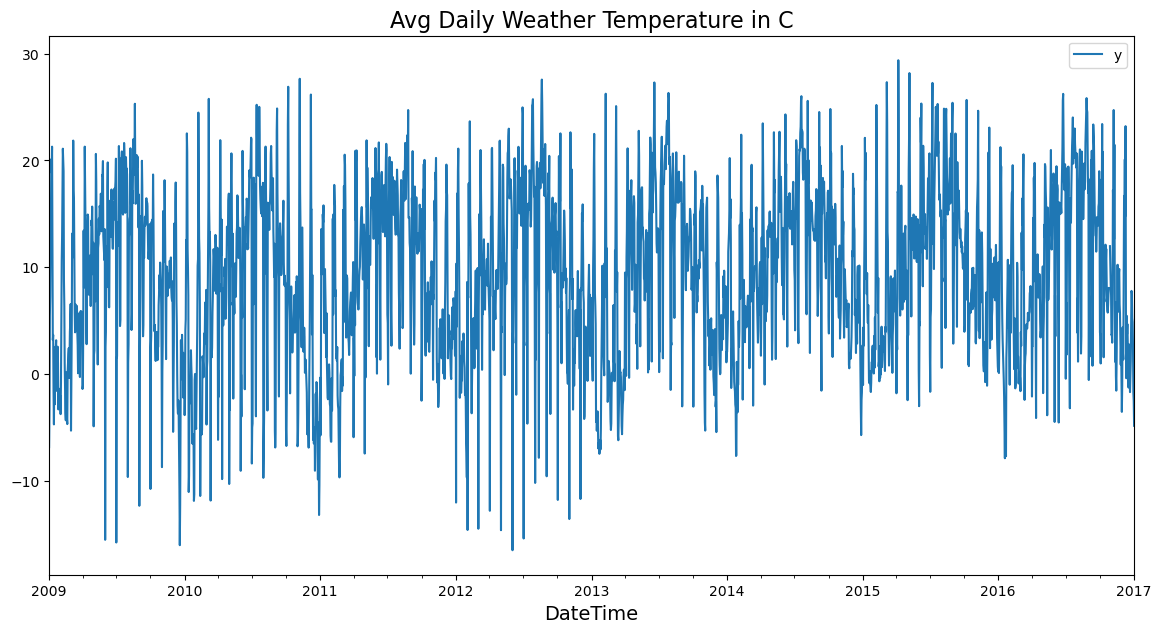

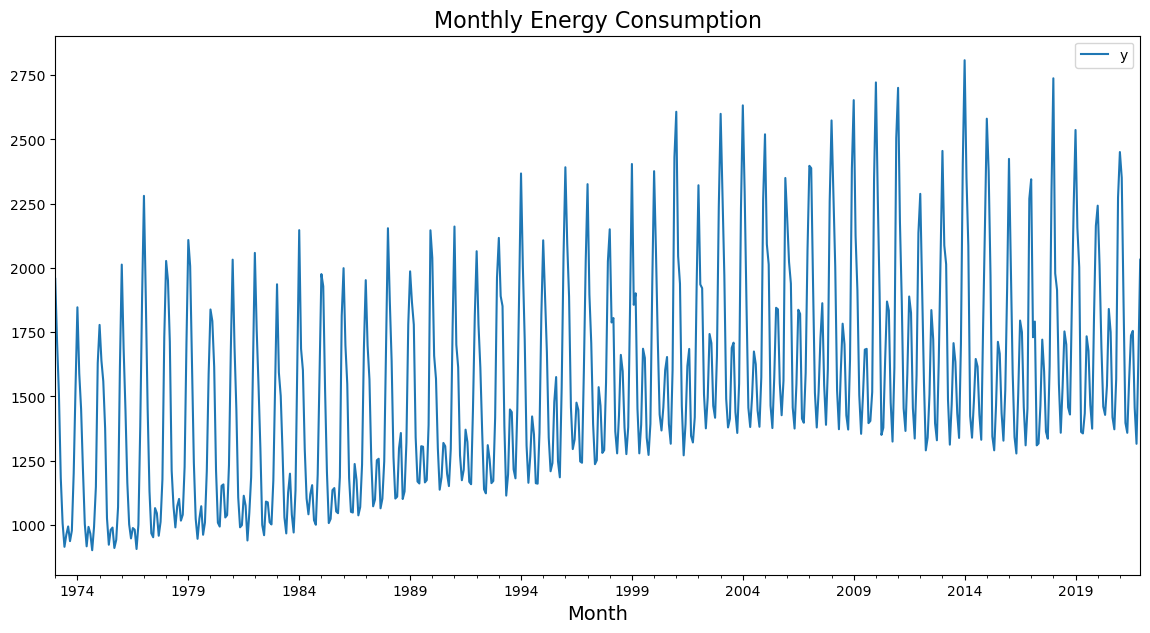

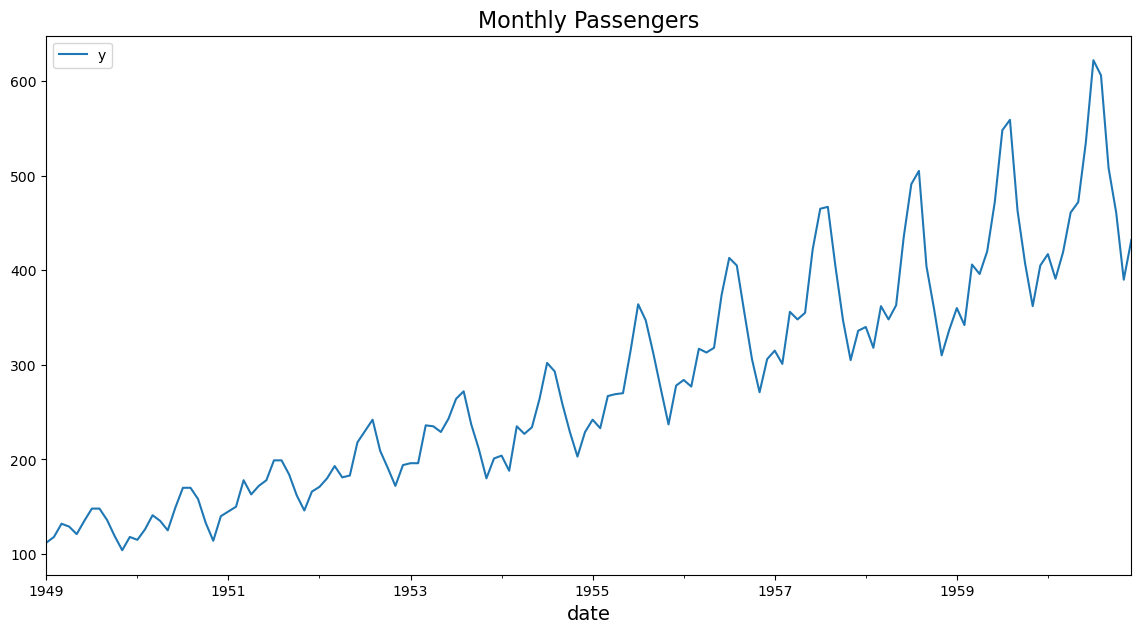

In [2]:
path = r'./CodeAndDatasets/datasets/Ch13/'

daily_temp = pd.read_csv(path+'daily_weather.csv', 
                      index_col='DateTime', 
                      parse_dates=True)
daily_temp.columns = ['y']
energy = pd.read_csv(path+'energy_consumption.csv', 
                     index_col='Month', 
                     parse_dates=True)
energy.columns = ['y']

air = pd.read_csv(path+'air_passenger.csv', 
                  index_col='date', 
                  parse_dates=True)
air.columns = ['y']

daily_temp.index.freq = 'D'
energy.index.freq = 'MS'
air.index.freq = 'M'

print(daily_temp.index.freq)
print(energy.index.freq)
print(air.index.freq)

## visualizing the time series data

daily_temp.plot(title='Avg Daily Weather Temperature in C')
energy.plot(title='Monthly Energy Consumption')
air.plot(title='Monthly Passengers')



In [3]:
## Transform datasets

air_cp = air.copy()
en_cp = energy.copy()
dw_cp = daily_temp.copy()


def handle_missing_data(df):
    n = int(df.isna().sum())
    if n > 0:
        print(f'found {n} missing observations...')
        df.ffill(inplace=True)
        
        
def one_step_forecast(df, window):
    d = df.values
    x = []
    n = len(df)
    idx = df.index[:-window]
    for start in range(n-window):
        end = start + window
        x.append(d[start:end])
    cols = [f'x_{i}' for i in range(1, window+1)]
    x = np.array(x).reshape(n-window, -1)
    y = df.iloc[window:].values
    df_xs = pd.DataFrame(x, columns=cols, index=idx)
    df_y = pd.DataFrame(y.reshape(-1), columns=['y'], index=idx)
    return pd.concat([df_xs, df_y], axis=1).dropna()
    

def split_data(df, test_split=0.15):
    n = int(len(df) * test_split)
    train, test = df[:-n], df[-n:]
    return train, test

for df in [air_cp, en_cp, dw_cp]:
    handle_missing_data(df)


air_df = one_step_forecast(air_cp, 10)
en_df = one_step_forecast(en_cp, 10)
dw_df = one_step_forecast(dw_cp, 10)
print(air_df.shape)
print(en_df.shape)
print(dw_df.shape)

## Scale and Split data

class Standardize:
    def __init__(self, df, split=0.10):
        self.data = df
        self.split = split
    
    def split_data(self):
        n = int(len(self.data) * self.split)
        train, test = self.data.iloc[:-n], self.data.iloc[-n:]
        n = int(len(train) * self.split)
        train, val = train.iloc[:-n], train.iloc[-n:]
        assert len(test) + len(train) + len(val) == len(self.data)
        return train, test, val
    
    def _transform(self, data):
        data_s = (data - self.mu)/self.sigma
        return data_s
    
    def fit_transform(self):
        train, test, val = self.split_data()
        self.mu, self.sigma = train.mean(), train.std()
        train_s = self._transform(train)
        test_s = self._transform(test)
        val_s = self._transform(val)
        return train_s, test_s, val_s
    
    def inverse(self, data):
        return (data * self.sigma)+self.mu
        
    def inverse_y(self, data):
        return (data * self.sigma[-1])+self.mu[-1]

scale_air = Standardize(air_df)
scale_dw = Standardize(dw_df)
scale_en = Standardize(en_df)

train_air, test_air, val_air = scale_air.fit_transform()
train_dw, test_dw, val_dw = scale_dw.fit_transform()
train_en, test_en, val_en = scale_en.fit_transform()

print(f'''
air: train: {len(train_air)} , test: {len(test_air)}, val:{len(val_air)}
weather: train: {len(train_dw)} , test: {len(test_dw)}, val:{len(val_dw)}
energy: train: {len(train_en)} , test: {len(test_en)}, val: {len(val_en)}
''')

scale_air.inverse(train_air).head()

found 2 missing observations...
(134, 11)
(578, 11)
(2913, 11)

air: train: 109 , test: 13, val:12
weather: train: 2360 , test: 291, val:262
energy: train: 469 , test: 57, val: 52



,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
date,,,,,,,,,,,
1949-01-31,112.0,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0
1949-02-28,118.0,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0
1949-03-31,132.0,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0
1949-04-30,129.0,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0
1949-05-31,121.0,135.0,148.0,148.0,136.0,119.0,104.0,118.0,115.0,126.0,141.0


In [4]:
## split into X and Y (Features and Target)

def features_target_ts(*args):
    y = [col.pop('y').values.reshape(-1, 1) for col in args]
    x = [col.values.reshape(*col.shape, 1)
                   for col in args]
    return *y, *x

(y_train_air, 
 y_val_air, 
 y_test_air, 
 x_train_air, 
 x_val_air, 
 x_test_air) = features_target_ts(train_air, 
                               val_air, 
                               test_air)


(y_train_dw, 
y_val_dw, 
y_test_dw, 
x_train_dw, 
x_val_dw, 
x_test_dw) = features_target_ts(train_dw, 
                             val_dw, 
                             test_dw)


(y_train_en, 
y_val_en, 
y_test_en, 
x_train_en, 
x_val_en, 
x_test_en) = features_target_ts(train_en, 
                             val_en, 
                             test_en)


print(x_train_air.shape,
x_test_air.shape,
x_val_air.shape)

print(y_train_air.shape,
y_test_air.shape,
y_val_air.shape)

(109, 10, 1) (13, 10, 1) (12, 10, 1)
(109, 1) (13, 1) (12, 1)


## Forecasting with Keras

A network with more than one hidden layer is considered a deep neural network. There are three layers – an input layer, a hidden layer, and an output layer.

Neurons in the hidden layer perform a mathematical function like a simple linear transformation - 𝑋1 × 𝑊11 + 𝑋2 × 𝑊21. 

Improving how neurons pass information from one layer to another is done by adding an activation function. ex: -  Sigmoid, ReLU, or Tanh are for hidden layer. for example when you apply RELU activation function, then RELU is applied around linear transformation making it to capture non-linear relationships.

common output layer activation functions are sigmoid (for binary or multi label), softmax (for multclass) or linear (for Regression).

When an entire dataset passes through all the layers in a forward direction (forward propagation) and then again in a reverse backward direction (backward propagation), this cycle is what we call an epoch (one complete pass)

Once the data goes through forward propagation to compute the output from the input (training) data, the estimated value(s) are compared with the actual known observations. The weights (𝑊11,𝑊12, …) are the parameters that the model estimates (learns) through the fitting or training process. 
Initially weights are initialized by a random values and these are adjusted therough the backward propagation process based on loss funciton that network wants to minimize.



### Forecasting with an RNN using Keras

In RNNs, there is a feedback loop where the output of one node or neuron is fed back (the recursive part) as input, allowing the network to learn from a prior time step acting as a memory

In [5]:
from tensorflow.keras import Sequential
from tensorflow import keras
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from keras.layers import (BatchNormalization, Dense, TimeDistributed,
                            Bidirectional, SimpleRNN, GRU, LSTM, Dropout)

## SimpleRNN

def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(SimpleRNN(units=units,
                        return_sequences=False,
                        input_shape=(train.shape[1], 
                                     train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model


def train_model_ts(model, 
                x_train, y_train, x_val, y_val, 
                epochs=500, 
                patience=12, 
                batch_size=32):
    
    model.compile(optimizer='adam', 
                  loss='mean_squared_error', 
                  metrics=[RootMeanSquaredError(), 
                           MeanAbsoluteError()])
    
    es = keras.callbacks.EarlyStopping( # when loss stops dropping 
                         # EarlyStopping class helps to stop the training 
                         # instead of completing all epoches
                    monitor="val_loss", 
                    min_delta=0, 
                    patience=patience) # its an integer as threshold 
                    # representing the number of epochs with no improvements
                    # before stopping the training
    
    history = model.fit(x_train,y_train, 
              shuffle=False, epochs=epochs,
              batch_size=batch_size, 
              validation_data=(x_val, y_val),
              callbacks=[es], verbose=1)
    return history


def plot_forecast(model, x_test, y_test, index, history):
    fig, ax = plt.subplots(2, 1)
    (pd.Series(history.history['loss'])
                      .plot(style='k',alpha=0.50, title='Loss by Epoch',
                            ax = ax[0], label='loss'))
    (pd.Series(history.history['val_loss'])
                      .plot(style='k',ax=ax[0],label='val_loss'))
    ax[0].legend()
    predicted = model.predict(x_test)
    pd.Series(y_test.reshape(-1), 
              index=index).plot(style='k--', alpha=0.5, ax=ax[1], 
                                title='Forecast vs Actual',
                                label='actual')
    pd.Series(predicted.reshape(-1), 
              index=index).plot(
            style='k',label='Forecast', ax=ax[1])
    fig.tight_layout()
    ax[1].legend();plt.show()
          # tanh activation function is popular choice for RNNs, LSTMs, GRUs

In [6]:
### Air Passenger

tf.keras.backend.clear_session()

model_a_simpleRNN = create_model(train=x_train_air, units=32)

model_a_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [7]:
history_a_simpleRNN = train_model_ts(model_a_simpleRNN, x_train_air, y_train_air, x_val_air, y_val_air)

Epoch 1/500
4/4 [==============================] - 6s 108ms/step - loss: 1.8016 - root_mean_squared_error: 1.3422 - mean_absolute_error: 1.0962 - val_loss: 5.6525 - val_root_mean_squared_error: 2.3775 - val_mean_absolute_error: 2.0626
Epoch 2/500
4/4 [==============================] - 0s 19ms/step - loss: 1.1523 - root_mean_squared_error: 1.0734 - mean_absolute_error: 0.8611 - val_loss: 4.3707 - val_root_mean_squared_error: 2.0906 - val_mean_absolute_error: 1.7563
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.8373 - root_mean_squared_error: 0.9150 - mean_absolute_error: 0.7292 - val_loss: 3.4322 - val_root_mean_squared_error: 1.8526 - val_mean_absolute_error: 1.5199
Epoch 4/500
4/4 [==============================] - 0s 21ms/step - loss: 0.7202 - root_mean_squared_error: 0.8486 - mean_absolute_error: 0.6669 - val_loss: 2.7715 - val_root_mean_squared_error: 1.6648 - val_mean_absolute_error: 1.3303
Epoch 5/500
4/4 [==============================] - 0s 21ms/step

dict_keys(['loss', 'root_mean_squared_error', 'mean_absolute_error', 'val_loss', 'val_root_mean_squared_error', 'val_mean_absolute_error'])
1/1 [==============================] - 0s 181ms/step


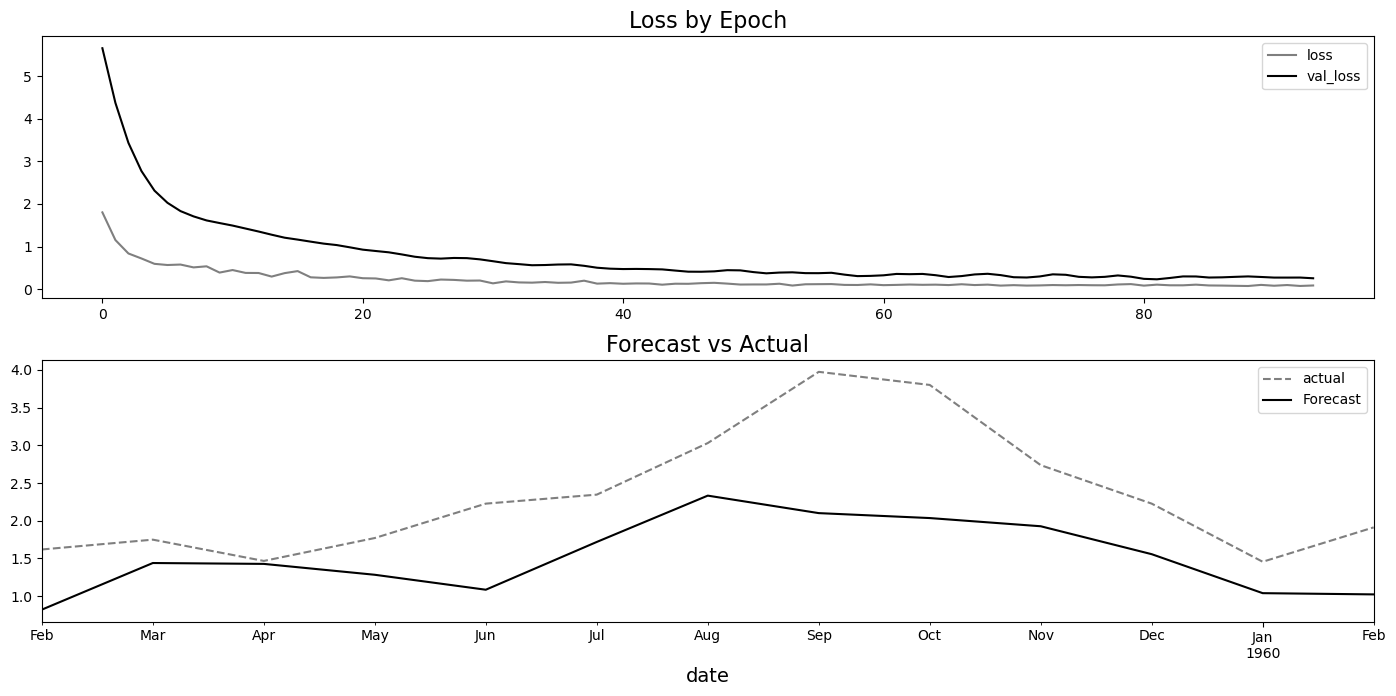

In [8]:
print(history_a_simpleRNN.history.keys())

model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air)

plot_forecast(model_a_simpleRNN, x_test_air, y_test_air, test_air.index, history_a_simpleRNN)

In [9]:
### Avg Daily Temp

tf.keras.backend.clear_session()

model_dw_simpleRNN = create_model(x_train_dw, units=32)

model_dw_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [10]:
history_dw_simpleRNN = train_model_ts(model_dw_simpleRNN, x_train_dw, y_train_dw, x_val_dw, y_val_dw, batch_size=64)

Epoch 1/500
37/37 [==============================] - 1s 16ms/step - loss: 0.5372 - root_mean_squared_error: 0.7329 - mean_absolute_error: 0.5319 - val_loss: 0.3708 - val_root_mean_squared_error: 0.6089 - val_mean_absolute_error: 0.4663
Epoch 2/500
37/37 [==============================] - 0s 12ms/step - loss: 0.4735 - root_mean_squared_error: 0.6881 - mean_absolute_error: 0.4943 - val_loss: 0.3772 - val_root_mean_squared_error: 0.6142 - val_mean_absolute_error: 0.4646
Epoch 3/500
37/37 [==============================] - 0s 13ms/step - loss: 0.4577 - root_mean_squared_error: 0.6765 - mean_absolute_error: 0.4831 - val_loss: 0.3806 - val_root_mean_squared_error: 0.6169 - val_mean_absolute_error: 0.4659
Epoch 4/500
37/37 [==============================] - 0s 12ms/step - loss: 0.4347 - root_mean_squared_error: 0.6593 - mean_absolute_error: 0.4677 - val_loss: 0.3785 - val_root_mean_squared_error: 0.6152 - val_mean_absolute_error: 0.4643
Epoch 5/500
37/37 [==============================] - 0s 

10/10 [==============================] - 0s 4ms/step


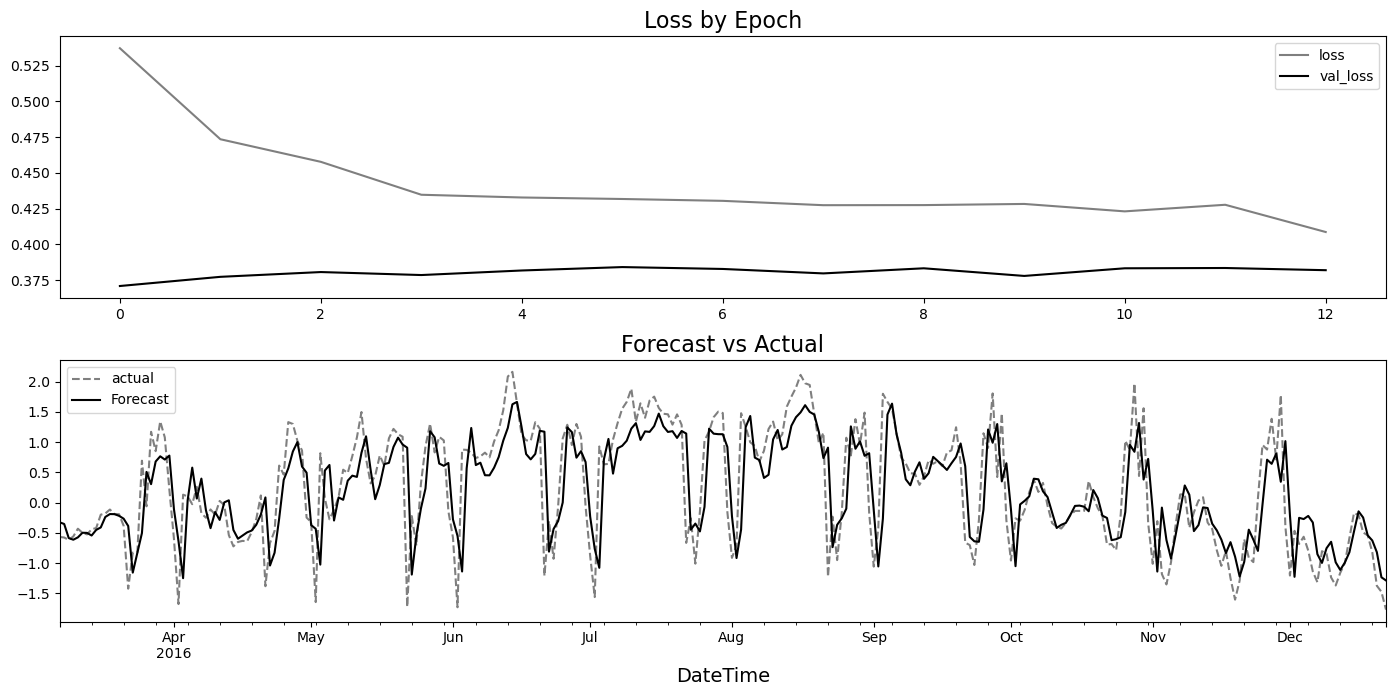

In [11]:
model_dw_simpleRNN.evaluate(x=x_test_dw, y=y_test_dw)

plot_forecast(model_dw_simpleRNN, x_test_dw, y_test_dw, test_dw.index, history_dw_simpleRNN)

In [12]:
### Energy consumption

tf.keras.backend.clear_session()

model_en_simpleRNN = create_model(x_train_en, units=32)
model_en_simpleRNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


Epoch 1/500
8/8 [==============================] - 1s 38ms/step - loss: 1.6456 - root_mean_squared_error: 1.2828 - mean_absolute_error: 1.0480 - val_loss: 1.4949 - val_root_mean_squared_error: 1.2226 - val_mean_absolute_error: 0.8850
Epoch 2/500
8/8 [==============================] - 0s 16ms/step - loss: 1.0828 - root_mean_squared_error: 1.0406 - mean_absolute_error: 0.8548 - val_loss: 1.1534 - val_root_mean_squared_error: 1.0740 - val_mean_absolute_error: 0.8041
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 0.7865 - root_mean_squared_error: 0.8869 - mean_absolute_error: 0.7262 - val_loss: 0.8853 - val_root_mean_squared_error: 0.9409 - val_mean_absolute_error: 0.7267
Epoch 4/500
8/8 [==============================] - 0s 15ms/step - loss: 0.5911 - root_mean_squared_error: 0.7689 - mean_absolute_error: 0.6261 - val_loss: 0.6786 - val_root_mean_squared_error: 0.8238 - val_mean_absolute_error: 0.6510
Epoch 5/500
8/8 [==============================] - 0s 13ms/step 

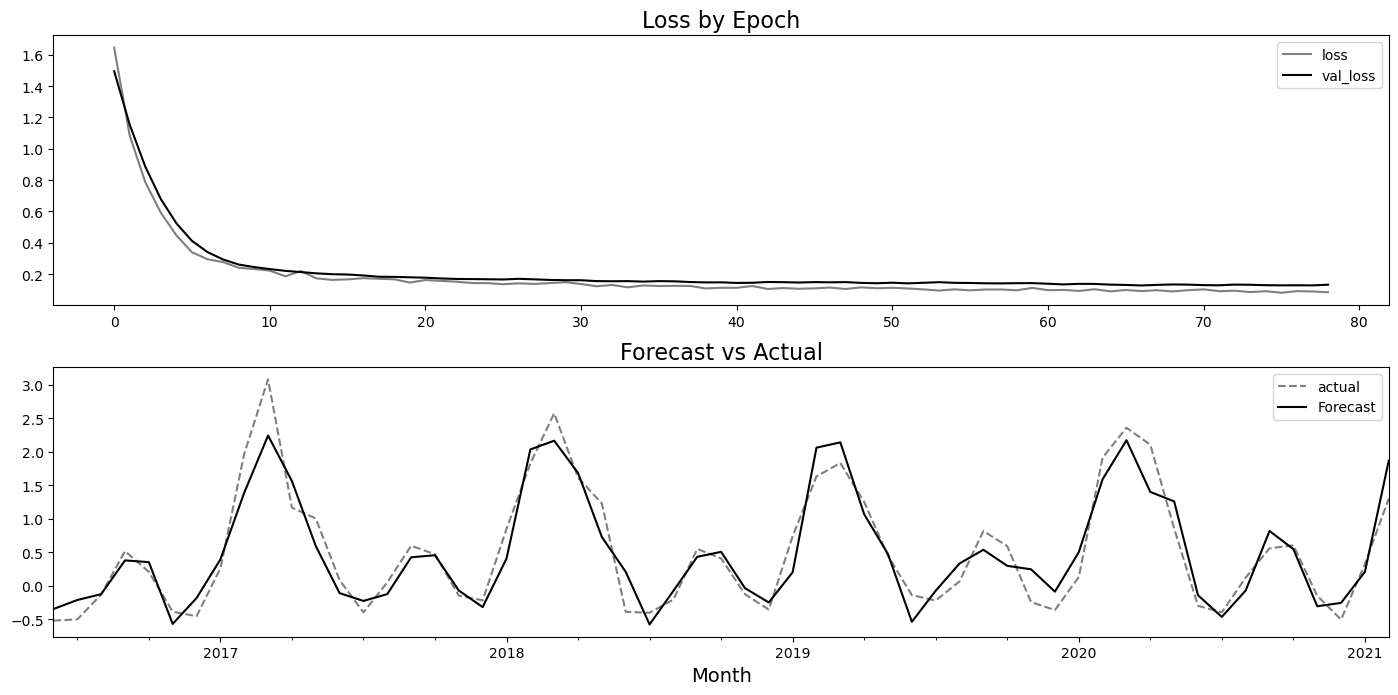

In [13]:
history_en_simpleRNN = train_model_ts(model_en_simpleRNN, x_train_en, y_train_en, x_val_en, y_val_en, batch_size=64)

model_en_simpleRNN.evaluate(x=x_test_en, y=y_test_en)

plot_forecast(model_en_simpleRNN, x_test_en, y_test_en, test_en.index, history_en_simpleRNN)

In [14]:
print(scale_en.inverse_y(y_test_en[0:5]))

print(scale_en.inverse_y(model_en_simpleRNN.predict(x_test_en)[0:5]))


[[1309.744]
 [1316.979]
 [1463.766]
 [1721.174]
 [1598.033]]
2/2 [==============================] - 0s 4ms/step
[[1378.4829]
 [1431.6423]
 [1466.4117]
 [1666.21  ]
 [1655.7491]]


### Forecasting with LSTM using Keras

RNN's memory is short term and does not do well when persisting a longer-term memory. 

in deep RNN, with multiple hidden layers, the network with suffer vanishing gradient problem -> during back propagarion, it will be unable to change the weights of much earlier layers, redusing its ability to learn. so, output is influenced by closer layers.

If ong term memory is needed, then LSTM offers robust solution to RNNs.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/500
4/4 [==============================] - 2s 115ms/step - loss: 1.1086 - root_mean_squared_error: 1.0529 - mean_absolute_error: 0.8792 - val_loss: 3.9919 - val_root_mean_squared_error: 1.9980 - val_mean_absolute_error: 1.8350
Epoch 2/500
4/4 [==============================] - 0s 18ms/step - loss: 0.9534

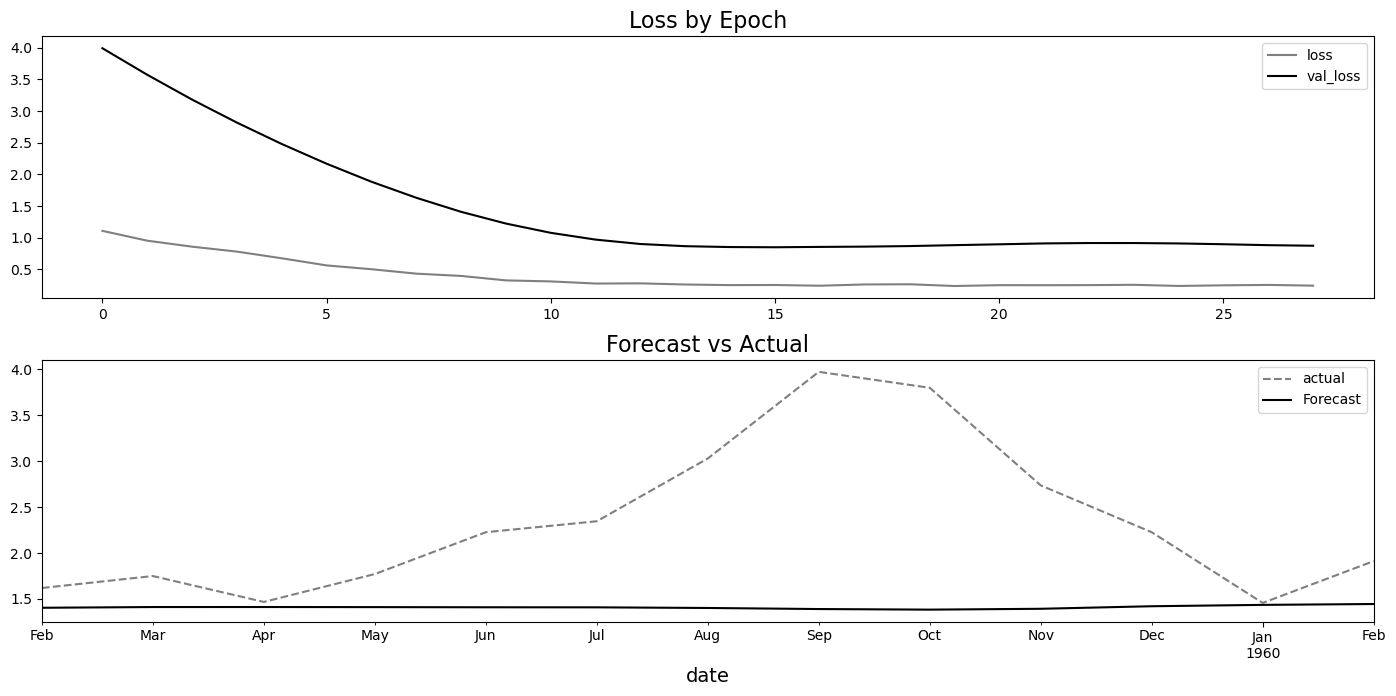

In [15]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,
                   input_shape=(train.shape[1], 
                                train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

## Air passenger

tf.keras.backend.clear_session()

model_a_lstm = create_model(train=x_train_air, units=32)
print(model_a_lstm.summary())

history_a_lstm = train_model_ts(model_a_lstm, x_train_air, y_train_air, x_val_air, y_val_air)

model_a_lstm.evaluate(x=x_test_air, y=y_test_air)

plot_forecast(model_a_lstm, x_test_air, y_test_air, test_air.index, history_a_lstm)

Epoch 1/500
4/4 [==============================] - 3s 183ms/step - loss: 0.9571 - root_mean_squared_error: 0.9783 - mean_absolute_error: 0.8126 - val_loss: 3.4698 - val_root_mean_squared_error: 1.8627 - val_mean_absolute_error: 1.6910
Epoch 2/500
4/4 [==============================] - 0s 29ms/step - loss: 0.7761 - root_mean_squared_error: 0.8810 - mean_absolute_error: 0.7183 - val_loss: 2.9208 - val_root_mean_squared_error: 1.7090 - val_mean_absolute_error: 1.5163
Epoch 3/500
4/4 [==============================] - 0s 31ms/step - loss: 0.6263 - root_mean_squared_error: 0.7914 - mean_absolute_error: 0.6291 - val_loss: 2.4072 - val_root_mean_squared_error: 1.5515 - val_mean_absolute_error: 1.3320
Epoch 4/500
4/4 [==============================] - 0s 25ms/step - loss: 0.4964 - root_mean_squared_error: 0.7045 - mean_absolute_error: 0.5507 - val_loss: 1.9236 - val_root_mean_squared_error: 1.3869 - val_mean_absolute_error: 1.1313
Epoch 5/500
4/4 [==============================] - 0s 24ms/step

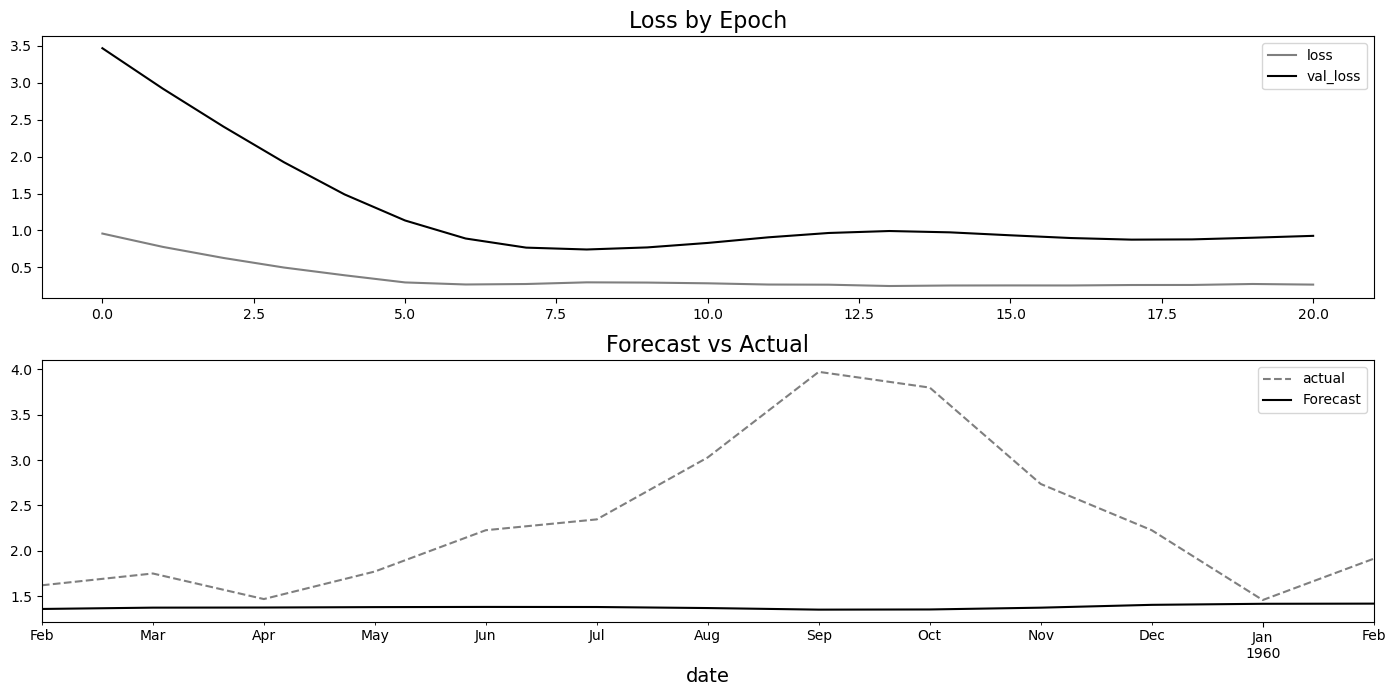

Epoch 1/500
4/4 [==============================] - 3s 178ms/step - loss: 0.9827 - root_mean_squared_error: 0.9913 - mean_absolute_error: 0.8236 - val_loss: 3.5902 - val_root_mean_squared_error: 1.8948 - val_mean_absolute_error: 1.7263
Epoch 2/500
4/4 [==============================] - 0s 21ms/step - loss: 0.8593 - root_mean_squared_error: 0.9270 - mean_absolute_error: 0.7606 - val_loss: 3.2096 - val_root_mean_squared_error: 1.7915 - val_mean_absolute_error: 1.6050
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.7576 - root_mean_squared_error: 0.8704 - mean_absolute_error: 0.7030 - val_loss: 2.8385 - val_root_mean_squared_error: 1.6848 - val_mean_absolute_error: 1.4727
Epoch 4/500
4/4 [==============================] - 0s 19ms/step - loss: 0.6659 - root_mean_squared_error: 0.8160 - mean_absolute_error: 0.6469 - val_loss: 2.4880 - val_root_mean_squared_error: 1.5773 - val_mean_absolute_error: 1.3292
Epoch 5/500
4/4 [==============================] - 0s 28ms/step

ValueError: Length of values (130) does not match length of index (13)

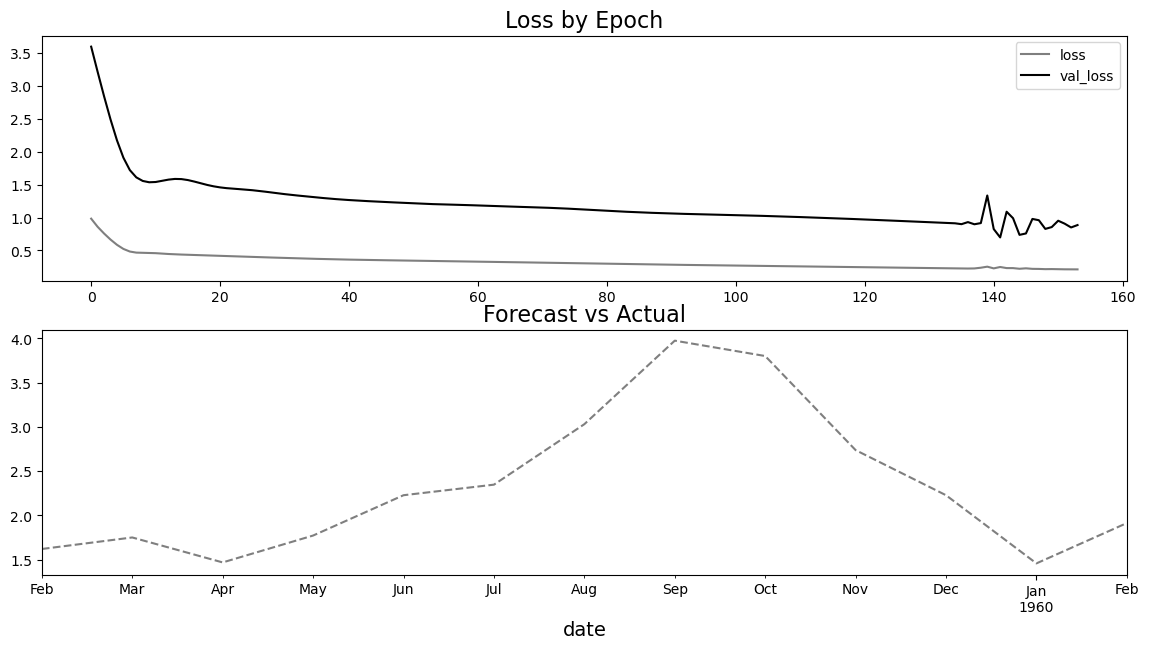

### Forecasting with GRU using Keras

The GRU is a simplified version of the LSTM with only two gates (the update and reset gates) and one state – the hidden state (ℎ𝑡).

Epoch 1/500
4/4 [==============================] - 1s 110ms/step - loss: 0.7699 - root_mean_squared_error: 0.8774 - mean_absolute_error: 0.7073 - val_loss: 2.7622 - val_root_mean_squared_error: 1.6620 - val_mean_absolute_error: 1.4961
Epoch 2/500
4/4 [==============================] - 0s 17ms/step - loss: 0.6017 - root_mean_squared_error: 0.7757 - mean_absolute_error: 0.6300 - val_loss: 2.3613 - val_root_mean_squared_error: 1.5366 - val_mean_absolute_error: 1.3597
Epoch 3/500
4/4 [==============================] - 0s 17ms/step - loss: 0.5342 - root_mean_squared_error: 0.7309 - mean_absolute_error: 0.5797 - val_loss: 1.9864 - val_root_mean_squared_error: 1.4094 - val_mean_absolute_error: 1.2178
Epoch 4/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4588 - root_mean_squared_error: 0.6773 - mean_absolute_error: 0.5294 - val_loss: 1.6488 - val_root_mean_squared_error: 1.2840 - val_mean_absolute_error: 1.0737
Epoch 5/500
4/4 [==============================] - 0s 18ms/step

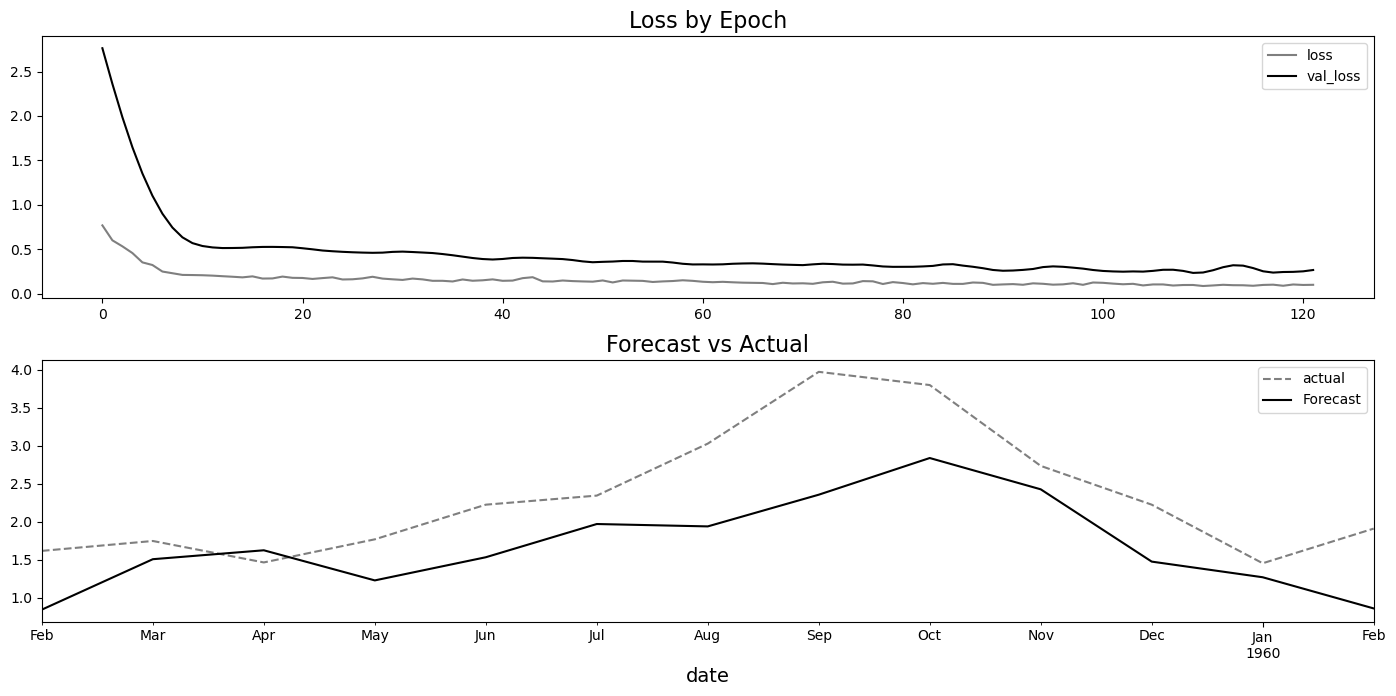

In [ ]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(GRU(units=units,
                  input_shape=(train.shape[1], 
                               train.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

## Air passengers
tf.keras.backend.clear_session()

model_a_gru = create_model(train=x_train_air, units=32)
history_a_gru = train_model_ts(model_a_gru, x_train_air, y_train_air, x_val_air, y_val_air)

plot_forecast(model_a_gru, x_test_air, y_test_air, test_air.index, history_a_gru)


#### Deep RNN-LSTM

Epoch 1/500
4/4 [==============================] - 2s 192ms/step - loss: 0.9277 - root_mean_squared_error: 0.9632 - mean_absolute_error: 0.7974 - val_loss: 3.3891 - val_root_mean_squared_error: 1.8410 - val_mean_absolute_error: 1.6680
Epoch 2/500
4/4 [==============================] - 0s 25ms/step - loss: 0.7676 - root_mean_squared_error: 0.8761 - mean_absolute_error: 0.7072 - val_loss: 2.7446 - val_root_mean_squared_error: 1.6567 - val_mean_absolute_error: 1.4567
Epoch 3/500
4/4 [==============================] - 0s 29ms/step - loss: 0.5757 - root_mean_squared_error: 0.7588 - mean_absolute_error: 0.6012 - val_loss: 2.1433 - val_root_mean_squared_error: 1.4640 - val_mean_absolute_error: 1.2263
Epoch 4/500
4/4 [==============================] - 0s 21ms/step - loss: 0.4612 - root_mean_squared_error: 0.6791 - mean_absolute_error: 0.5186 - val_loss: 1.5939 - val_root_mean_squared_error: 1.2625 - val_mean_absolute_error: 0.9677
Epoch 5/500
4/4 [==============================] - 0s 21ms/step

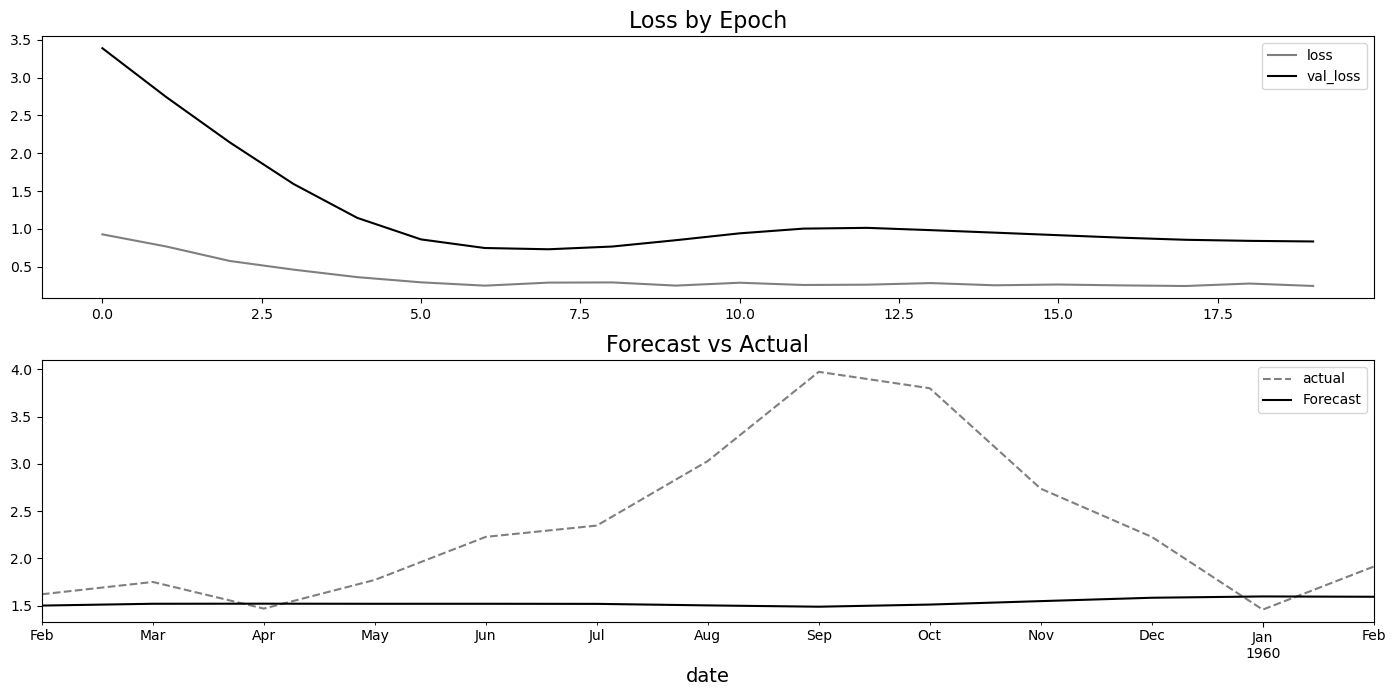

In [23]:
tf.keras.backend.clear_session()

def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units,input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(Dropout(dropout))
    model.add(LSTM(units=units))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

model_a_deep = create_model(train=x_train_air, units=32)
history_a_deep = train_model_ts(model_a_deep, x_train_air, y_train_air, x_val_air, y_val_air)

model_a_deep.evaluate(x_test_air, y_test_air)

plot_forecast(model_a_deep, x_test_air, y_test_air, test_air.index, history_a_deep)

#### Bidirectional LSTM


Epoch 1/500
4/4 [==============================] - 5s 303ms/step - loss: 0.9932 - root_mean_squared_error: 0.9966 - mean_absolute_error: 0.8242 - val_loss: 3.0365 - val_root_mean_squared_error: 1.7426 - val_mean_absolute_error: 1.5593
Epoch 2/500
4/4 [==============================] - 0s 27ms/step - loss: 0.6706 - root_mean_squared_error: 0.8189 - mean_absolute_error: 0.6550 - val_loss: 2.0320 - val_root_mean_squared_error: 1.4255 - val_mean_absolute_error: 1.1872
Epoch 3/500
4/4 [==============================] - 0s 22ms/step - loss: 0.4409 - root_mean_squared_error: 0.6640 - mean_absolute_error: 0.5178 - val_loss: 1.2493 - val_root_mean_squared_error: 1.1177 - val_mean_absolute_error: 0.8232
Epoch 4/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3100 - root_mean_squared_error: 0.5568 - mean_absolute_error: 0.4451 - val_loss: 0.7869 - val_root_mean_squared_error: 0.8871 - val_mean_absolute_error: 0.6676
Epoch 5/500
4/4 [==============================] - 0s 25ms/step

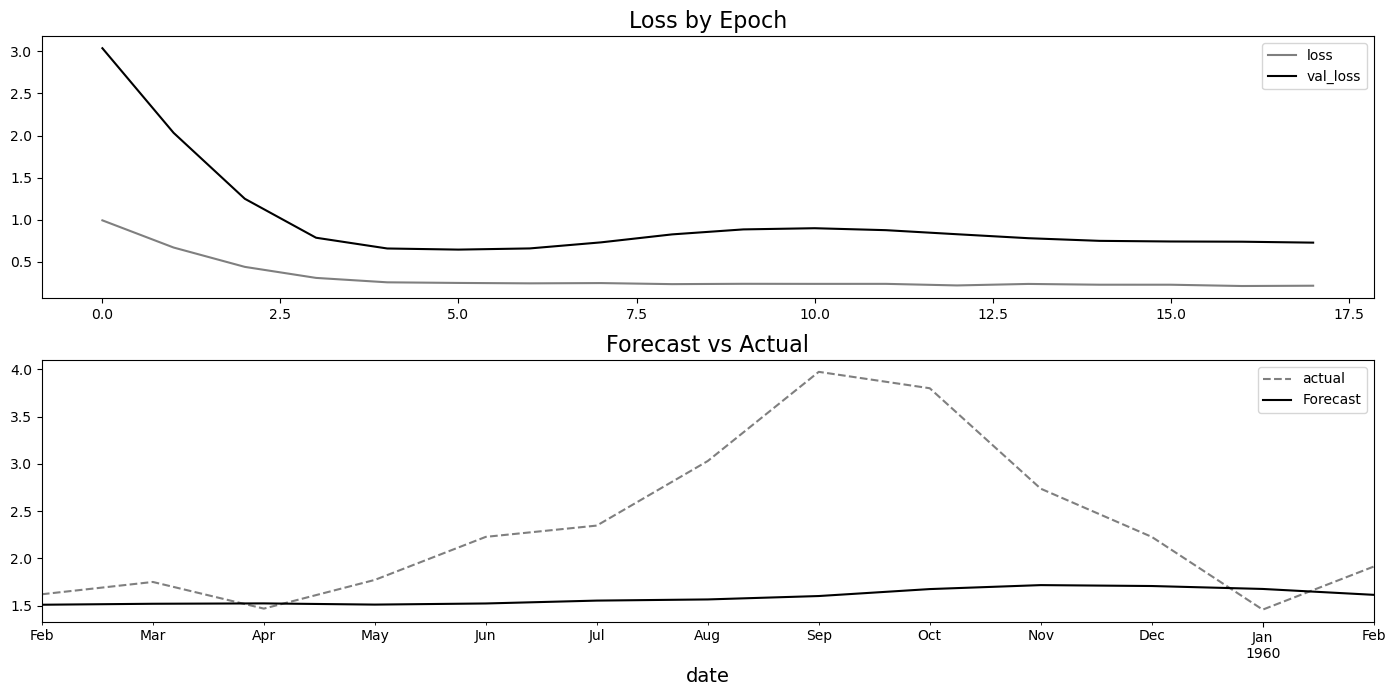

In [25]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(Bidirectional(LSTM(units=units, 
                                 input_shape=(train.shape[1], train.shape[2]), return_sequences=True)))
    model.add(Bidirectional(LSTM(units=units, return_sequences=False)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    
    return model

## Air passenger

tf.keras.backend.clear_session()

model_a_bd = create_model(train=x_train_air, units=32)
history_a_bd = train_model_ts(model_a_bd, x_train_air, y_train_air, x_val_air, y_val_air)

model_a_bd.evaluate(x=x_test_air, y=y_test_air)

plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)


#### Timedistributed

Epoch 1/500
4/4 [==============================] - 3s 197ms/step - loss: 0.9281 - root_mean_squared_error: 0.9634 - mean_absolute_error: 0.7967 - val_loss: 3.4023 - val_root_mean_squared_error: 1.8445 - val_mean_absolute_error: 1.6654
Epoch 2/500
4/4 [==============================] - 0s 32ms/step - loss: 0.8187 - root_mean_squared_error: 0.9048 - mean_absolute_error: 0.7378 - val_loss: 3.0333 - val_root_mean_squared_error: 1.7416 - val_mean_absolute_error: 1.5394
Epoch 3/500
4/4 [==============================] - 0s 27ms/step - loss: 0.7262 - root_mean_squared_error: 0.8522 - mean_absolute_error: 0.6833 - val_loss: 2.6642 - val_root_mean_squared_error: 1.6323 - val_mean_absolute_error: 1.3954
Epoch 4/500
4/4 [==============================] - 0s 20ms/step - loss: 0.6414 - root_mean_squared_error: 0.8009 - mean_absolute_error: 0.6317 - val_loss: 2.3140 - val_root_mean_squared_error: 1.5212 - val_mean_absolute_error: 1.2476
Epoch 5/500
4/4 [==============================] - 0s 20ms/step

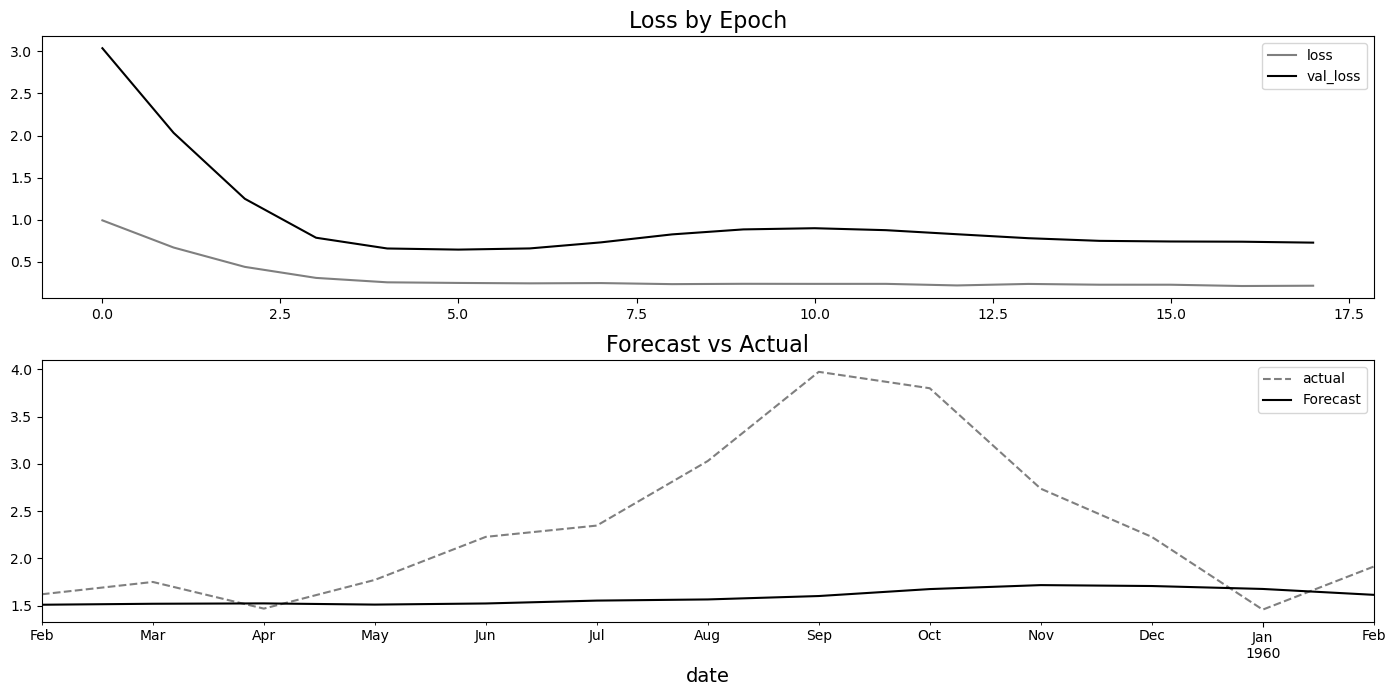

In [27]:
def create_model(train, units, dropout=0.2):
    model = keras.Sequential()
    model.add(LSTM(units=units, input_shape=(train.shape[1], train.shape[2]), return_sequences=True))
    model.add(LSTM(units=units, return_sequences=True))
    model.add(TimeDistributed(Dense(1)))
    
    return model
## Air passenger
tf.keras.backend.clear_session()
model_a_td = create_model(train=x_train_air, units=32)
history_a_td = train_model_ts(model_a_td, x_train_air, y_train_air, x_val_air, y_val_air)

model_a_td.evaluate(x=x_test_air, y=y_test_air)


plot_forecast(model_a_bd, x_test_air, y_test_air, test_air.index, history_a_bd)


In [28]:
### compare all deep learning techniques for time series

scores = pd.DataFrame(np.array(
    [model_a_simpleRNN.evaluate(x=x_test_air, y=y_test_air),
    model_a_lstm.evaluate(x=x_test_air, y=y_test_air),
    model_a_gru.evaluate(x=x_test_air, y=y_test_air),
    model_a_deep.evaluate(x=x_test_air, y=y_test_air),
    model_a_bd.evaluate(x=x_test_air, y=y_test_air),
    model_a_td.evaluate(x=x_test_air, y=y_test_air)]), 
            columns=['MSE', 'RMSE', 'MAE'],
            index=['SimpleRNN', 'LSTM', 'GRU', 'Deep LSTM', 'Bidirectional', 'TimeDistributed'])
scores.sort_values('RMSE')

1/1 [==============================] - 0s 37ms/step - loss: 2.2151 - root_mean_squared_error: 1.4883 - mean_absolute_error: 1.2740


,MSE,RMSE,MAE
GRU,0.622625,0.789066,0.671539
SimpleRNN,0.910333,0.954114,0.809074
Bidirectional,1.154586,1.074516,0.783035
Deep LSTM,1.310245,1.144659,0.829980
LSTM,1.513577,1.230275,0.922263
TimeDistributed,2.215056,1.488306,1.274016


### Using Keras Model API


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 10, 32)            4352      
                                                                 
 dropout (Dropout)           (None, 10, 32)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable p

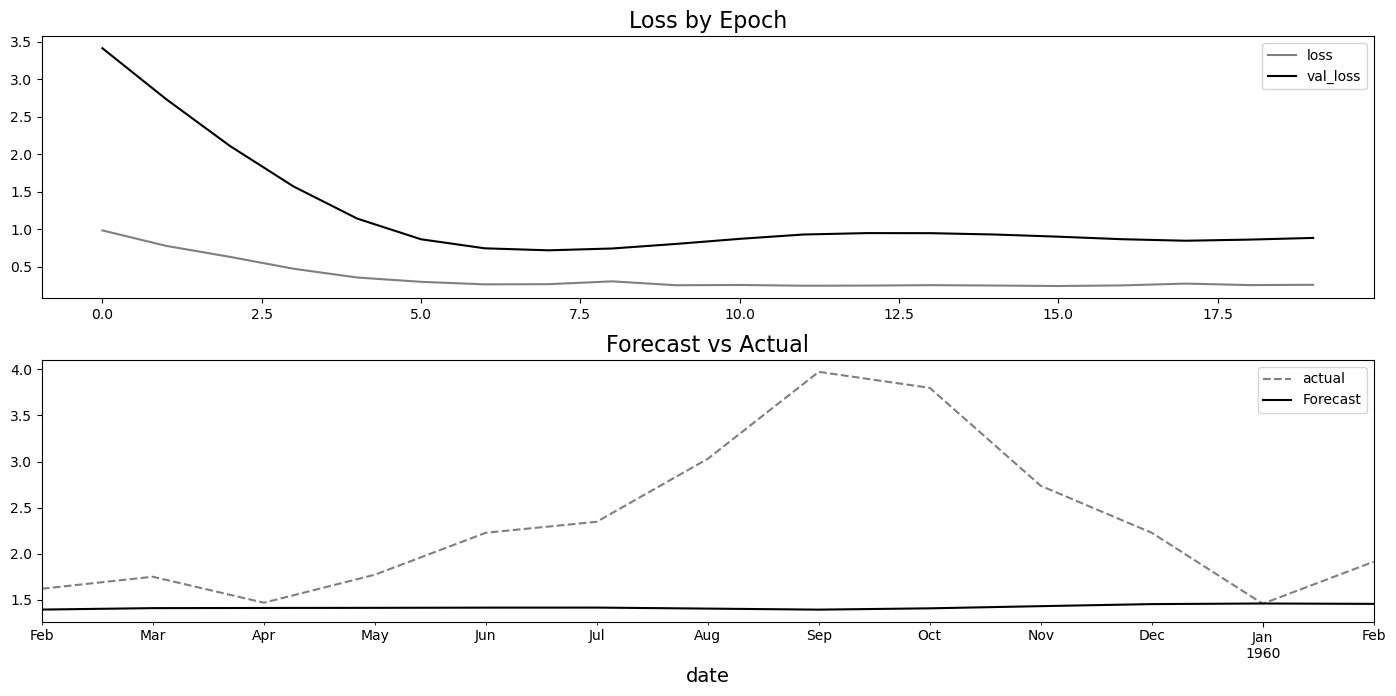

In [30]:
from tensorflow.keras import Model
from tensorflow import keras
from tensorflow.keras.metrics import (RootMeanSquaredError, 
                                     MeanAbsoluteError)
from keras.layers import (Dense,  
                LSTM, Dropout, 
                Input, Activation)


from tensorflow.keras import Model
from keras.layers import (Dense,  
                SimpleRNN, Dropout, 
                Input)

def create_model(train, units, dropout=0.2):
    
    input_data = Input(shape=(10,1))
    rnn = SimpleRNN(units, return_sequences=True)(input_data)
    dropout = Dropout(dropout)(rnn)
    output = Dense(1)(dropout)
    model = Model(inputs=input_data, outputs=output)
    return model

from tensorflow.keras import Model
from keras.layers import (Dense,  
                SimpleRNN, Dropout, 
                Input)

def create_model(train, units, dropout=0.2):
    
    input_data = Input(shape=(10,1))
    lstm_1 = LSTM(units, return_sequences=True)(input_data)
    dropout_1 = Dropout(dropout)(lstm_1)
    lstm_2 = LSTM(units)(dropout_1)
    dropout_2 = Dropout(dropout)(lstm_2)
    output = Dense(1)(dropout_2)
    model = Model(inputs=input_data, outputs=output)
    
    return model

tf.keras.backend.clear_session()

model_a_m = create_model(train=x_train_air, units=32)
model_a_m.summary()

history_a_m = train_model_ts(model_a_m, x_train_air, y_train_air, x_val_air, y_val_air)

model_a_m.evaluate(x=x_test_air, y=y_test_air)


plot_forecast(model_a_m, x_test_air, y_test_air, test_air.index, history_a_m)